In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense,Dropout,Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
x_data = np.load('lip/lip_x_data.npy') # x_save.npy
y_data = np.load('lip/lip_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
print("x_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

x_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [4]:
class VGG_LSTM_fine(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(VGG_LSTM_fine, self).__init__()
        self.vgg = VGG16(weights='imagenet', include_top=False,
                         input_shape=(input_shape[2], input_shape[3], input_shape[4]))
        self.vgg.trainable = False

        set_trainable = False
        for layer in self.vgg.layers:
            if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3' or layer.name == 'block5_pool':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        self.vggDistributed = TimeDistributed(self.vgg)        
        self.bilstm = layers.Bidirectional(layers.LSTM(256), merge_mode='concat')
        self.dense = layers.Dense(num_classes, activation='softmax')
#         self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout = layers.Dropout(0.2)
        self.flat= TimeDistributed(Flatten())
        
    def call(self, x):
        x = self.vggDistributed(x)
        x = self.flat(x)
        x = self.dropout(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return x

In [5]:
def get_model_vgg_fine():
    return VGG_LSTM_fine(input_shape = (32, 27, 64, 64, 3), num_classes = 11)

In [6]:
model = get_model_vgg_fine()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
model.load_weights("finetuned_vgg_bilstm") 
print("Loaded model from disk")

Loaded model from disk


In [8]:
print(X_test.shape, Y_test.shape)

(600, 27, 64, 64, 3) (600, 11)


In [9]:
predictions = model.predict(X_test)

In [10]:
#정답 비율 확인
answer = []
no_answer =[]

for i in range(600):
    true_label  = np.argmax(Y_test[i])
    predictions_array  = np.argmax(predictions[i])  
    if true_label == predictions_array:
        answer.append(true_label)
    else:
        no_answer.append(true_label)

In [11]:
print(len(answer), len(no_answer)) # 76, 524

525 75


In [13]:
per = []
for i in range(1, 11):
    per.append(answer.count(i)/60)

In [14]:
class_words = ['Begin', 'Choose','Connection', 'Navigation', 'Next','Previous','Start', 'Stop', 'Hello', 'Web']
class_sen = ['Stop navigation', 'Excuse me.', 'I am sorry.', 'Thank you.', 'Good bye.', 'I love this game.', 'Nice to meet you.', 'You are welcome.', 'How are you?', 'Have a good time.']

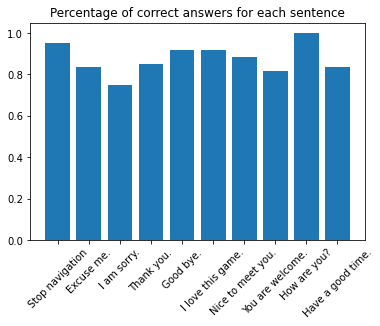

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Percentage of correct answers for each sentence')

y = np.arange(10)
plt.bar(y, per)
plt.xticks(y, class_sen, rotation = 45)
plt.show()
#plt.bar(y, per, align='edge', color="skyblue", edgecolor="black", linewidth=3, tick_label=y, log=False)
#plt.show()

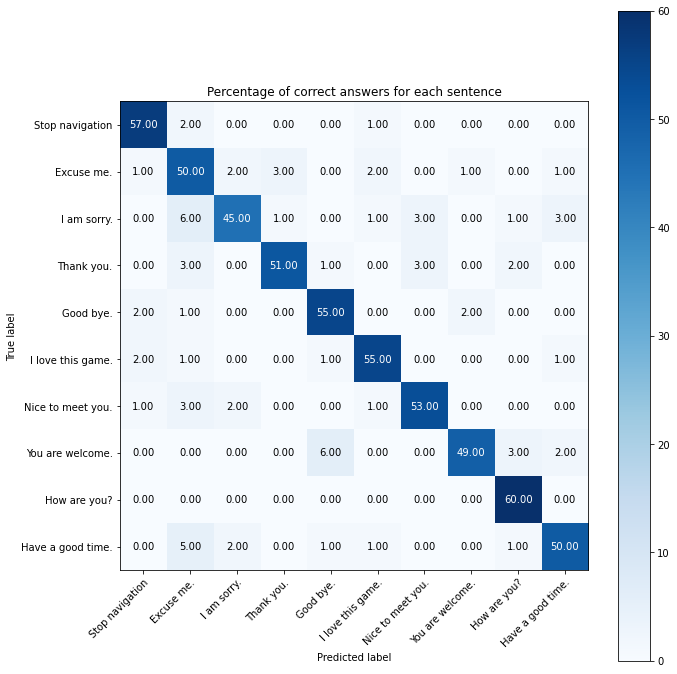

In [16]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(np.argmax(Y_test, axis=1),np.argmax(predictions, axis=1))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_sen, yticklabels=class_sen, title='Percentage of correct answers for each sentence',
           ylabel='True label', xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), fontsize = 10,ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()